# CVAE on generating flux vacua

Trying to improve the performance with more hidden layers and dropout layer to avoid overfitting.

## Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import numpy as np

## Define onehot function

In [2]:
def label_to_onehot(x, max_dim):
    """
    Convert a list of labels to one-hot encoded vectors for values in [0, max_dim - 1].
    
    Args:
        x: list of labels for the input images
        max_dim (int): number of possible classes (the size of onehot vector)
    """
    batch_size = x.shape[0] # number of samples in the batch
    vector = torch.zeros(batch_size, max_dim).to(x.device) # to(x.device) ensures the onehot vector tensor 
                                                           # is on the same device (CPU/GPU) as x
    for i in range(batch_size):
        vector[i,x[i]] = 1
    return vector

In [3]:
def coordinate_to_onehot(coord, max_dim=20+1):
    """
    Convert a coordinate vector to a concatenated one-hot encoded vector for values in [-10, 10].
    
    Args:
        coord (torch.Tensor): A vector of integers in the range [-10, 10].
        max_dim (int): The number of dimensions for one-hot encoding (default is 21 for range [-10, 10]).
    
    Returns:
        torch.Tensor: A single concatenated one-hot encoded vector.
    """
    onehot_vectors = []  # List to store one-hot vectors for each coordinate
    for value in coord:
        onehot = torch.zeros(max_dim)
        onehot[int(value) + 10] = 1  # Shift value by +25 to make index non-negative
        onehot_vectors.append(onehot)
    
    # Concatenate all one-hot vectors into a single vector
    concatenated_onehot = torch.cat(onehot_vectors, dim=0)
    return concatenated_onehot

In [4]:
coordinate_to_onehot(coord=[1,2,-10])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model structure

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout = nn.Dropout(p=0)  # Dropout layer
        self.mu = nn.Linear(hidden_size // 2, latent_size)
        self.sigma = nn.Linear(hidden_size // 2, latent_size)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)  # Apply dropout after activation
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    

class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, num_logits, output_per_logit):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size // 2)
        self.linear3 = nn.Linear(hidden_size // 2, num_logits * output_per_logit)
        self.dropout = nn.Dropout(p=0)  # Dropout layer
        self.num_logits = num_logits
        self.output_per_logit = output_per_logit

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.relu(self.linear2(x))
        x = self.dropout(x)
        logits = self.linear3(x)
        logits = logits.view(-1, self.num_logits, self.output_per_logit)
        return logits.unbind(dim=1)


class CVAE(nn.Module):
    def __init__(self, input_size, output_size, condition_size, latent_size, hidden_size, num_logits=8):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size + condition_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size + condition_size, hidden_size, num_logits, output_size // num_logits)
        
    def forward(self, x, c):
        x = torch.cat((x, c), dim=1)  # Concatenate input and condition
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma)  # Sample from standard normal
        z = mu + eps * sigma  # Reparameterization trick
        z = torch.cat((z, c), dim=1)  # Concatenate latent vector with condition
        # z = z + torch.normal(mean=0, std=0.1, size=z.size()).to(z.device)  # Add small noise
        logits = self.decoder(z)  # Dynamically unpack logits
        return logits, mu, sigma

## Loss function

In [6]:
loss_CE = nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

## Model parameters

In [7]:
latent_size = 128 # latent space dimension
hidden_size = 128 # hidden layer dimension
input_size = output_size = (20+1) * 8 # input_size for 8D coordinates 
condition_size = 2

## Training parameters

In [8]:
epochs = 30
batch_size = 128
learning_rate = 1e-3
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model construction

In [9]:
model = CVAE(input_size, output_size, condition_size, latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
try:
    model.load_state_dict(torch.load(modelname))
    print('[INFO] Load Model complete')
except:
    pass

## Prepare for dataset

In [10]:
a = torch.tensor([1,2,3])
b = torch.tensor([2,2,1])
c = torch.dot(a, b)
print(c)

tensor(9)


In [11]:
def N_flux(coord):
    return coord[0]*coord[6] + coord[1]*coord[7] - coord[2]*coord[4] - coord[3]*coord[5]

In [12]:
import random

train_dataset = []
test_dataset = []

n_train = 7000
n_test = 1500

train_set_visualise = []
N_flux_data = []
W0_data = []

# set a random vector for and take the dot product between the random vector and coord
random_vector = torch.tensor([random.randint(0, 5) for _ in range(8)])

for j in range(n_train):
    f = torch.tensor([random.randint(3, 10), random.randint(-5, 2), random.randint(6, 10), random.randint(-10, 5)])
    h = torch.tensor([random.randint(-10, 5), random.randint(-5, 8), random.randint(0, 10), random.randint(-10, 5)])
    coord = torch.cat((f, h))
    train_set_visualise.append(coord)

    N_flux_value = N_flux(coord)
    W0 = torch.dot(coord, random_vector)

    N_flux_data.append(N_flux_value)
    W0_data.append(W0)

x1 = np.percentile(N_flux_data, 33)
x2 = np.percentile(N_flux_data, 66)
z1 = np.percentile(W0_data, 33)
z2 = np.percentile(W0_data, 66)

for j in range(n_train):
    if x1 < N_flux_data[j] < x2 and z1 < W0_data[j] < z2:
        label = 0
    else:
        label = 1

    onehot_coord = coordinate_to_onehot(train_set_visualise[j])  # Convert to one-hot
    data_point = (onehot_coord, label)  # Store one-hot encoded vector with label
    train_dataset.append(data_point)


for j in range(n_test):
    f = torch.tensor([random.randint(3, 10), random.randint(-5, 2), random.randint(6, 10), random.randint(-10, 5)])
    h = torch.tensor([random.randint(-10, 5), random.randint(-5, 8), random.randint(0, 10), random.randint(-10, 5)])
    coord = torch.cat((f, h))

    W0 = torch.dot(coord, random_vector)

    if x1 < N_flux_value < x2 and z1 < W0 < z2:
        label = 0
    else:
        label = 1

    onehot_coord = coordinate_to_onehot(coord)  # Convert to one-hot
    data_point = (onehot_coord, label)  # Store one-hot encoded vector with label
    test_dataset.append(data_point)

In [13]:
n = 3
coord = train_set_visualise[n]
coord1 = train_dataset[n]
print(coord)
print(f"N_flux value: {N_flux(coord)}")
print(f"W_0 value: {torch.dot(coord, random_vector)}")
print(coord1)

tensor([ 6,  2,  6, -4, -9,  6,  9, -5])
N_flux value: 122
W_0 value: 10
(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]), 1)


There is a total of 7000 data.


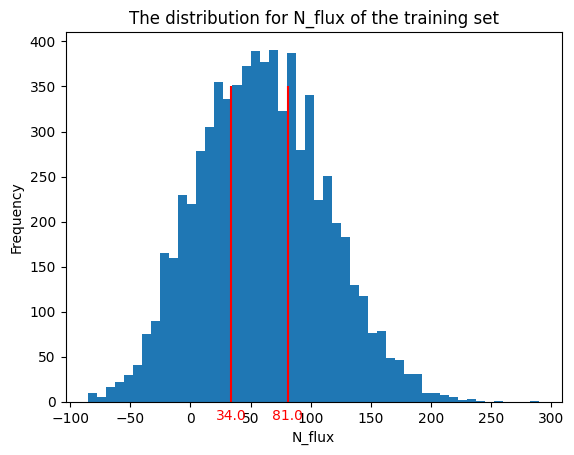

In [14]:
print(f"There is a total of {len(N_flux_data)} data.")
plt.hist(list(N_flux_data), bins=50)
plt.vlines(x1, 0, 350, color='red')
plt.vlines(x2, 0, 350, color='red')
plt.text(x1, -20, f'{x1}', color='red', ha='center')
plt.text(x2, -20, f'{x2}', color='red', ha='center')
plt.xlabel("N_flux")
plt.ylabel("Frequency")
plt.title("The distribution for N_flux of the training set")
plt.show()

There is a total of 7000 data.


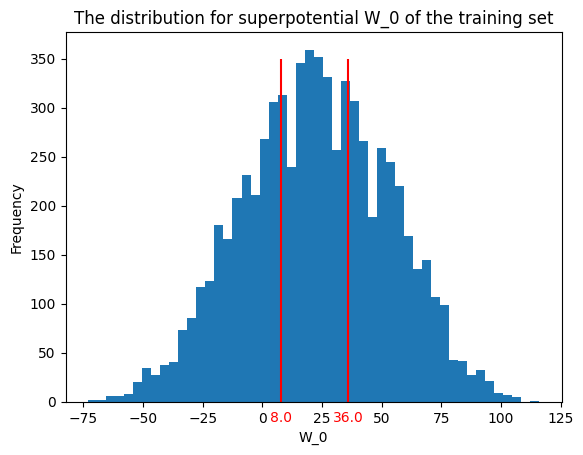

In [15]:
print(f"There is a total of {len(W0_data)} data.")
plt.hist(list(W0_data), bins=50)
plt.vlines(z1, 0, 350, color='red')
plt.vlines(z2, 0, 350, color='red')
plt.text(z1, -20, f'{z1}', color='red', ha='center')
plt.text(z2, -20, f'{z2}', color='red', ha='center')
plt.xlabel("W_0")
plt.ylabel("Frequency")
plt.title("The distribution for superpotential W_0 of the training set")
plt.show()

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model training

In [17]:
def cluster_loss(latent_space, labels):
    """
    Penalizes clusters in the latent space that are too close to each other.
    Args:
        latent_space (torch.Tensor): Latent space vectors (batch_size, latent_size).
        labels (torch.Tensor): Integer labels (batch_size).
    Returns:
        torch.Tensor: The cluster loss value.
    """
    unique_labels = torch.unique(labels)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = latent_space[labels == label]
        cluster_centers.append(cluster_points.mean(dim=0))
    cluster_centers = torch.stack(cluster_centers)
    pairwise_distances = torch.cdist(cluster_centers, cluster_centers)
    return torch.sum(torch.exp(-pairwise_distances))  # Penalize clusters that are too close


# Training loop
modelname = 'cvae_pytorch_flux_vacua_8.pth'

for epoch in range(epochs):   
    '''Model Training'''
    train_loss = 0  # Reset loss for each epoch

    for imgs, lbls in tqdm(train_loader, desc=f'[train] epoch: {epoch}'):
        bs = imgs.shape[0]
        imgs = imgs.view(bs, input_size).to(device)
        lbls_onehot = label_to_onehot(lbls.to(device), condition_size)

        # Forward pass
        logits, mu, sigma = model(imgs, lbls_onehot)  # logits is a tuple of 8 logits
        
        # Calculate targets dynamically
        targets = [imgs[:, i * 21:(i + 1) * 21].argmax(dim=1) for i in range(8)]

        # Calculate categorical cross-entropy losses
        loss_re = sum(loss_CE(logit, target) for logit, target in zip(logits, targets))

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)

        # Cluster loss
        latent_space = mu
        cluster_loss_value = cluster_loss(latent_space, lbls)


        # Combine the losses 
        beta = 0.5
        gamma = 2  # Weight for the cluster loss term
        loss = loss_re + beta * loss_norm + gamma * cluster_loss_value

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Record total loss
        train_loss += loss.item()

    # Print average loss
    print(f'epoch: {epoch} | Train Loss: {train_loss / len(train_loader.dataset):.4f}')

    # Evaluate the model
    model.eval()
    test_loss = 0
    for imgs, lbls in tqdm(test_loader, desc=f'[eval] epoch: {epoch}'):
        bs = imgs.shape[0]
        imgs = imgs.view(bs, input_size).to(device)
        lbls_onehot = label_to_onehot(lbls.to(device), condition_size)

        # Forward pass
        logits, mu, sigma = model(imgs, lbls_onehot)

        # Calculate targets dynamically
        targets = [imgs[:, i * 21:(i + 1) * 21].argmax(dim=1) for i in range(8)]

        # Calculate categorical cross-entropy losses
        loss_re = sum(loss_CE(logit, target) for logit, target in zip(logits, targets))

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)

        # Cluster loss
        latent_space = mu
        cluster_loss_value = cluster_loss(latent_space, lbls)

        # Combine the losses
        loss = loss_re + beta * loss_norm + gamma * cluster_loss_value

        # Record total loss
        test_loss += loss.item()

    # Print test loss
    print(f'epoch: {epoch} | Test Loss: {test_loss / len(test_loader.dataset):.4f}')
    model.train()

    print(f"Mu Mean: {mu.mean().item()}, Mu Std: {mu.std().item()}")

# Save the model
torch.save(model.state_dict(), modelname)
print(f"{modelname} is saved")

[train] epoch: 0:   0%|          | 0/55 [00:00<?, ?it/s]

[train] epoch: 0: 100%|██████████| 55/55 [00:00<00:00, 194.85it/s]


epoch: 0 | Train Loss: 78.9146


[eval] epoch: 0: 100%|██████████| 12/12 [00:00<00:00, 240.57it/s]


epoch: 0 | Test Loss: 7.4027
Mu Mean: 0.001994436141103506, Mu Std: 0.029774898663163185


[train] epoch: 1: 100%|██████████| 55/55 [00:00<00:00, 157.31it/s]


epoch: 1 | Train Loss: 2.2630


[eval] epoch: 1: 100%|██████████| 12/12 [00:00<00:00, 222.42it/s]


epoch: 1 | Test Loss: 0.6800
Mu Mean: -0.00022512678697239608, Mu Std: 0.020894652232527733


[train] epoch: 2: 100%|██████████| 55/55 [00:00<00:00, 244.06it/s]


epoch: 2 | Train Loss: 0.5248


[eval] epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 431.78it/s]


epoch: 2 | Test Loss: 0.3571
Mu Mean: 0.00011082457058364525, Mu Std: 0.018103361129760742


[train] epoch: 3: 100%|██████████| 55/55 [00:00<00:00, 275.19it/s]


epoch: 3 | Train Loss: 0.3446


[eval] epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 428.96it/s]


epoch: 3 | Test Loss: 0.2687
Mu Mean: 7.639139221282676e-05, Mu Std: 0.016238031908869743


[train] epoch: 4: 100%|██████████| 55/55 [00:00<00:00, 69.30it/s] 


epoch: 4 | Train Loss: 0.2907


[eval] epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 92.31it/s]


epoch: 4 | Test Loss: 0.2401
Mu Mean: 0.00041501791565679014, Mu Std: 0.014848860912024975


[train] epoch: 5: 100%|██████████| 55/55 [00:00<00:00, 192.28it/s]


epoch: 5 | Train Loss: 0.2735


[eval] epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 382.82it/s]


epoch: 5 | Test Loss: 0.2305
Mu Mean: 0.00028149643912911415, Mu Std: 0.013763688504695892


[train] epoch: 6: 100%|██████████| 55/55 [00:00<00:00, 252.27it/s]


epoch: 6 | Train Loss: 0.2670


[eval] epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 395.21it/s]


epoch: 6 | Test Loss: 0.2256
Mu Mean: 0.0005265119834803045, Mu Std: 0.0128372423350811


[train] epoch: 7: 100%|██████████| 55/55 [00:00<00:00, 246.57it/s]


epoch: 7 | Train Loss: 0.2631


[eval] epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 385.95it/s]


epoch: 7 | Test Loss: 0.2222
Mu Mean: 2.0433044483070262e-05, Mu Std: 0.011837294325232506


[train] epoch: 8: 100%|██████████| 55/55 [00:00<00:00, 119.27it/s]


epoch: 8 | Train Loss: 0.2599


[eval] epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 324.60it/s]


epoch: 8 | Test Loss: 0.2195
Mu Mean: 0.00011798120976891369, Mu Std: 0.011460576206445694


[train] epoch: 9: 100%|██████████| 55/55 [00:00<00:00, 229.39it/s]


epoch: 9 | Train Loss: 0.2571


[eval] epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 384.81it/s]


epoch: 9 | Test Loss: 0.2172
Mu Mean: 0.00036058967816643417, Mu Std: 0.011341040022671223


[train] epoch: 10: 100%|██████████| 55/55 [00:00<00:00, 244.25it/s]


epoch: 10 | Train Loss: 0.2547


[eval] epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 436.06it/s]


epoch: 10 | Test Loss: 0.2146
Mu Mean: 0.00032445494434796274, Mu Std: 0.010204466991126537


[train] epoch: 11: 100%|██████████| 55/55 [00:00<00:00, 252.13it/s]


epoch: 11 | Train Loss: 0.2523


[eval] epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 332.74it/s]


epoch: 11 | Test Loss: 0.2125
Mu Mean: 0.00019804833573289216, Mu Std: 0.009685967117547989


[train] epoch: 12: 100%|██████████| 55/55 [00:00<00:00, 227.70it/s]


epoch: 12 | Train Loss: 0.2502


[eval] epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 370.27it/s]


epoch: 12 | Test Loss: 0.2113
Mu Mean: 0.00037157017504796386, Mu Std: 0.010325362905859947


[train] epoch: 13: 100%|██████████| 55/55 [00:00<00:00, 241.47it/s]


epoch: 13 | Train Loss: 0.2483


[eval] epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 401.24it/s]


epoch: 13 | Test Loss: 0.2088
Mu Mean: 3.097565786447376e-05, Mu Std: 0.009211703203618526


[train] epoch: 14: 100%|██████████| 55/55 [00:00<00:00, 242.48it/s]


epoch: 14 | Train Loss: 0.2463


[eval] epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 241.16it/s]


epoch: 14 | Test Loss: 0.2075
Mu Mean: -0.00020877370843663812, Mu Std: 0.009267915040254593


[train] epoch: 15: 100%|██████████| 55/55 [00:00<00:00, 222.41it/s]


epoch: 15 | Train Loss: 0.2446


[eval] epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 317.77it/s]


epoch: 15 | Test Loss: 0.2054
Mu Mean: 0.00013995221524965018, Mu Std: 0.008344988338649273


[train] epoch: 16: 100%|██████████| 55/55 [00:00<00:00, 215.37it/s]


epoch: 16 | Train Loss: 0.2429


[eval] epoch: 16: 100%|██████████| 12/12 [00:00<00:00, 377.94it/s]


epoch: 16 | Test Loss: 0.2042
Mu Mean: 5.253312338027172e-06, Mu Std: 0.008405528962612152


[train] epoch: 17: 100%|██████████| 55/55 [00:00<00:00, 203.38it/s]


epoch: 17 | Train Loss: 0.2414


[eval] epoch: 17: 100%|██████████| 12/12 [00:00<00:00, 368.79it/s]


epoch: 17 | Test Loss: 0.2030
Mu Mean: 0.0001475717726862058, Mu Std: 0.009069769643247128


[train] epoch: 18: 100%|██████████| 55/55 [00:00<00:00, 232.06it/s]


epoch: 18 | Train Loss: 0.2399


[eval] epoch: 18: 100%|██████████| 12/12 [00:00<00:00, 389.08it/s]


epoch: 18 | Test Loss: 0.2013
Mu Mean: -7.71087798057124e-05, Mu Std: 0.008261751383543015


[train] epoch: 19: 100%|██████████| 55/55 [00:00<00:00, 234.87it/s]


epoch: 19 | Train Loss: 0.2386


[eval] epoch: 19: 100%|██████████| 12/12 [00:00<00:00, 372.18it/s]


epoch: 19 | Test Loss: 0.2001
Mu Mean: 0.0004184668359812349, Mu Std: 0.008127138949930668


[train] epoch: 20: 100%|██████████| 55/55 [00:00<00:00, 269.51it/s]


epoch: 20 | Train Loss: 0.2372


[eval] epoch: 20: 100%|██████████| 12/12 [00:00<00:00, 384.72it/s]


epoch: 20 | Test Loss: 0.1988
Mu Mean: -0.00015879828424658626, Mu Std: 0.00749504379928112


[train] epoch: 21: 100%|██████████| 55/55 [00:00<00:00, 257.38it/s]


epoch: 21 | Train Loss: 0.2358


[eval] epoch: 21: 100%|██████████| 12/12 [00:00<00:00, 403.30it/s]


epoch: 21 | Test Loss: 0.1985
Mu Mean: -0.00024004874285310507, Mu Std: 0.00873870775103569


[train] epoch: 22: 100%|██████████| 55/55 [00:00<00:00, 131.15it/s]


epoch: 22 | Train Loss: 0.2346


[eval] epoch: 22: 100%|██████████| 12/12 [00:00<00:00, 310.92it/s]


epoch: 22 | Test Loss: 0.1962
Mu Mean: -5.077453897683881e-05, Mu Std: 0.006977807730436325


[train] epoch: 23: 100%|██████████| 55/55 [00:00<00:00, 221.31it/s]


epoch: 23 | Train Loss: 0.2334


[eval] epoch: 23: 100%|██████████| 12/12 [00:00<00:00, 382.85it/s]


epoch: 23 | Test Loss: 0.1953
Mu Mean: 2.5576337066013366e-05, Mu Std: 0.007181084714829922


[train] epoch: 24: 100%|██████████| 55/55 [00:00<00:00, 252.13it/s]


epoch: 24 | Train Loss: 0.2321


[eval] epoch: 24: 100%|██████████| 12/12 [00:00<00:00, 391.21it/s]


epoch: 24 | Test Loss: 0.1945
Mu Mean: 0.00019749529019463807, Mu Std: 0.0073613366112113


[train] epoch: 25: 100%|██████████| 55/55 [00:00<00:00, 247.09it/s]


epoch: 25 | Train Loss: 0.2312


[eval] epoch: 25: 100%|██████████| 12/12 [00:00<00:00, 387.62it/s]


epoch: 25 | Test Loss: 0.1934
Mu Mean: -7.082043885020539e-05, Mu Std: 0.0071450769901275635


[train] epoch: 26: 100%|██████████| 55/55 [00:00<00:00, 238.17it/s]


epoch: 26 | Train Loss: 0.2301


[eval] epoch: 26: 100%|██████████| 12/12 [00:00<00:00, 388.77it/s]


epoch: 26 | Test Loss: 0.1934
Mu Mean: 0.00013998917711433023, Mu Std: 0.008651216514408588


[train] epoch: 27: 100%|██████████| 55/55 [00:00<00:00, 255.97it/s]


epoch: 27 | Train Loss: 0.2294


[eval] epoch: 27: 100%|██████████| 12/12 [00:00<00:00, 410.63it/s]


epoch: 27 | Test Loss: 0.1915
Mu Mean: -6.0269074310781434e-05, Mu Std: 0.006663082633167505


[train] epoch: 28: 100%|██████████| 55/55 [00:00<00:00, 232.49it/s]


epoch: 28 | Train Loss: 0.2283


[eval] epoch: 28: 100%|██████████| 12/12 [00:00<00:00, 377.49it/s]


epoch: 28 | Test Loss: 0.1906
Mu Mean: 6.788787140976638e-05, Mu Std: 0.00632775854319334


[train] epoch: 29: 100%|██████████| 55/55 [00:00<00:00, 238.19it/s]


epoch: 29 | Train Loss: 0.2274


[eval] epoch: 29: 100%|██████████| 12/12 [00:00<00:00, 356.32it/s]

epoch: 29 | Test Loss: 0.1902
Mu Mean: 2.790201506286394e-05, Mu Std: 0.007222538813948631
cvae_pytorch_flux_vacua_8.pth is saved


## Latent space plotting

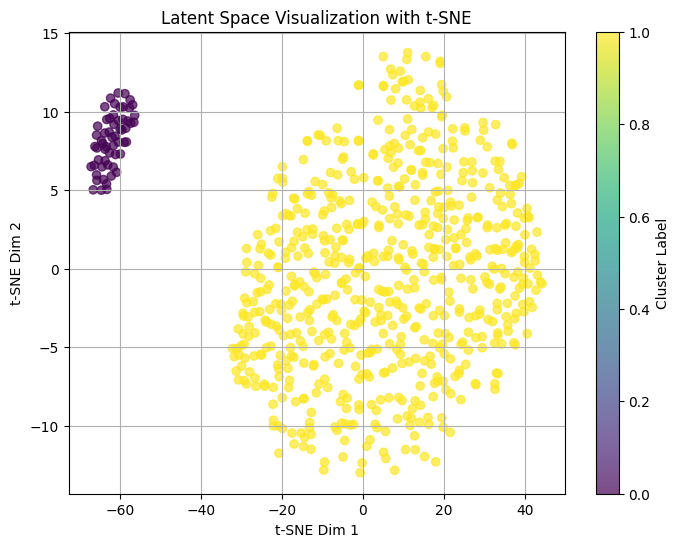

{np.int64(0): (array([ 0.02260436,  0.02378246,  0.03047337, -0.05631794,  0.00586086,
        0.02063101, -0.05671   ,  0.022431  , -0.01126269,  0.0563517 ,
       -0.00813027,  0.01235398, -0.01874589, -0.04784952, -0.00207008,
       -0.04884906, -0.00181543, -0.0356809 ,  0.015193  ,  0.03965433,
        0.00263301, -0.06124546, -0.01271274, -0.00136991, -0.07160051,
       -0.04423557, -0.02113982, -0.01233456,  0.0326229 ,  0.01617621,
        0.02147811, -0.00127233, -0.0164994 , -0.02014508,  0.02367324,
       -0.0036677 ,  0.02538772,  0.04024016, -0.01655871,  0.00294312,
       -0.03494394,  0.0241364 ,  0.04343011,  0.00491856,  0.00387428,
        0.04115749,  0.02508067,  0.02659555,  0.00471231, -0.01387829,
        0.01113753, -0.01422492,  0.02262071,  0.01532365,  0.02657464,
       -0.00838351,  0.02684829, -0.02574999,  0.02465291, -0.01985257,
        0.05140841, -0.02626036,  0.04558718, -0.01257186, -0.02308712,
        0.01053573, -0.02132851,  0.05535541,  0.

In [23]:
import sklearn
from sklearn.manifold import TSNE

def plot_latent_space_and_calculate_stats(model, data_loader, num_samples=n_train):
    model.eval()
    latent_vectors = []
    labels = []

    # Collect latent vectors for a subset of samples
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            
            # Get the latent vectors
            lbls_onehot = label_to_onehot(lbls, condition_size)
            mu, _ = model.encoder(torch.cat((imgs, lbls_onehot), dim=1))
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

            if len(latent_vectors) >= num_samples:
                break

    # Convert to numpy array
    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels)[:num_samples]

    # Compute cluster statistics: Mean and variance
    unique_labels = np.unique(labels)
    cluster_stats = {}
    for label in unique_labels:
        cluster_points = latent_vectors[labels == label]
        cluster_mean = np.mean(cluster_points, axis=0)
        cluster_var = np.var(cluster_points, axis=0)
        cluster_stats[label] = (cluster_mean, cluster_var)

    # Reduce dimensionality using t-SNE for visualization
    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(latent_vectors[:int(0.1 * len(latent_vectors))])

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        latent_2d[:, 0],
        latent_2d[:, 1],
        c=labels[:int(0.1 * len(latent_vectors))],
        cmap="viridis",
        alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster Label")
    plt.title("Latent Space Visualization with t-SNE")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()

    return cluster_stats

# Use the function to plot latent space and calculate cluster statistics
cluster_stats = plot_latent_space_and_calculate_stats(model, train_loader)
print(cluster_stats)

## Visualisation

In [19]:
'''Model prediction''' # use trained model or saved trained model to predict

def generate_sample_from_cluster(cluster_label, epsilon):
    """
    Generate a sample from the Gaussian distribution of the given cluster.

    Args:
        cluster_label (int): The cluster label (e.g., 0, 1).
        epsilon (float): Additional noise factor to add diversity to samples.

    Returns:
        list: Predicted coordinates from the generated sample.
    """
    # Retrieve mean and variance for the cluster
    cluster_mean, cluster_var = cluster_stats[cluster_label]

    # Convert mean and variance to tensors and move to the correct device
    cluster_mean = torch.tensor(cluster_mean, dtype=torch.float32, device=device)
    cluster_var = torch.tensor(cluster_var, dtype=torch.float32, device=device)

    # Sample from the Gaussian distribution
    epsilon_noise = torch.abs(torch.randn_like(cluster_mean)) * epsilon
    gaussian_sample = torch.normal(mean=cluster_mean, std=torch.sqrt(cluster_var) + epsilon_noise)

    # One-hot encode the label
    i_number = torch.tensor([cluster_label], dtype=torch.long, device=device)
    condit = label_to_onehot(i_number, condition_size)

    # Concatenate latent sample and condition
    inputs = torch.cat((gaussian_sample.unsqueeze(0), condit), dim=1)

    # Decode to predict coordinates
    with torch.no_grad():
        logits = model.decoder(inputs)

    # Convert logits to predicted coordinates
    predicted_coord = [logit.argmax(dim=1).item() - 10 for logit in logits]
    return predicted_coord


# Example usage
coord = generate_sample_from_cluster(cluster_label=0, epsilon=0.1)
print(f"Generated flux: {coord}")
print(N_flux(coord))

Generated flux: [5, 0, 6, 0, -3, 2, 5, -4]
43


The mean value of N_flux from the training set is 59.699.


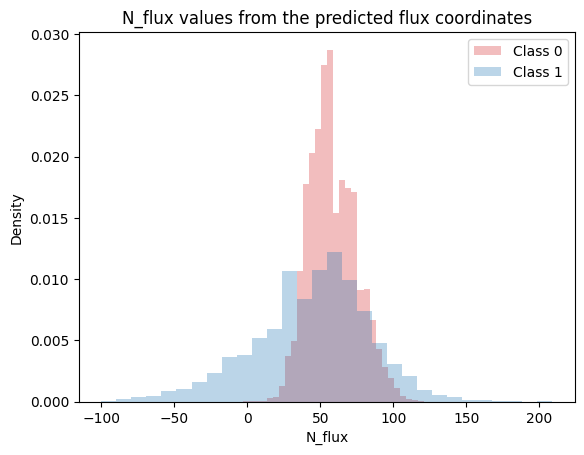

In [24]:
print(f"The mean value of N_flux from the training set is {np.mean(N_flux_data)}.")
plt.hist(np.array([N_flux(generate_sample_from_cluster(cluster_label=0, epsilon=2)) for i in range(10000)]), bins=30, alpha=0.3, color='tab:red', label='Class 0', density=True)
plt.hist(np.array([N_flux(generate_sample_from_cluster(cluster_label=1, epsilon=2)) for i in range(10000)]), bins=30, alpha=0.3, color='tab:blue', label='Class 1', density=True)
plt.legend()
plt.xlabel("N_flux")
plt.ylabel("Density")
plt.title("N_flux values from the predicted flux coordinates")
plt.show()

The mean value of W_0 from the training set is 22.579.


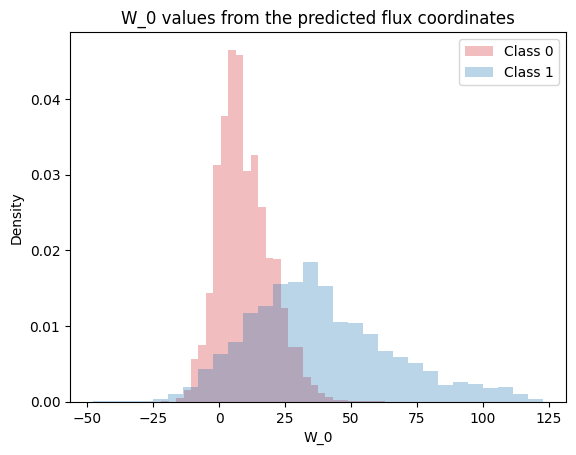

In [25]:
print(f"The mean value of W_0 from the training set is {np.mean(W0_data)}.")
plt.hist(
    np.array([torch.dot(torch.tensor(generate_sample_from_cluster(cluster_label=0, epsilon=2)), random_vector).item() for j in range(10000)]),
    bins=30,
    alpha=0.3,
    color='tab:red',
    label='Class 0',
    density=True
)

plt.hist(
    np.array([torch.dot(torch.tensor(generate_sample_from_cluster(cluster_label=1, epsilon=2)), random_vector).item() for j in range(10000)]),
    bins=30,
    alpha=0.3,
    color='tab:blue',
    label='Class 1',
    density=True
)

plt.legend()
plt.xlabel("W_0")
plt.ylabel("Density")
plt.title("W_0 values from the predicted flux coordinates")
plt.show()
